# Лабораторная работа 1

1) Классификация данных методом k ближайших соседей ( kNN)

2) Классификация данных методом опорных векторов (SVM)

3) Построение softmax-классификатора

Вариант 1: задания 1 и 2 на наборе данных CIFAR-10

Вариант 2: задания 1 и 2 на наборе данных MNIST

Вариант 3: задания 1 и 3 на наборе данных CIFAR-10

Вариант 4: задания 1 и 3 на наборе данных MNIST

Лабораторные работы можно выполнять с использованием сервиса Google Colaboratory (https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d) или на локальном компьютере. 

## 1. Классификация данных методом k ближайших соседей ( kNN)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scripts.data_utils import load_CIFAR10
import itertools
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold
from scipy.stats import mode
import time


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

1.1 Скачайте данные в соответсвии с заданием.

CIFAR-10 по ссылке https://www.cs.toronto.edu/~kriz/cifar.html
или используйте  команду !bash get_datasets.sh (google colab, local ubuntu)

MNIST 
sklearn.datasets import load_digits
digits = load_digits()

In [49]:
cifar10_dir = 'scripts/datasets/cifar-10-batches-py'

try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
#X_train, _, y_train, _ = train_test_split(X_train, y_train, test_size=0.95, random_state=42)
#X_test, _, y_test, _ = train_test_split(X_test, y_test, test_size=0.95, random_state=42)

print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


1.2 Выведите несколько примеров изображений из обучающей выборки для каждого класса.



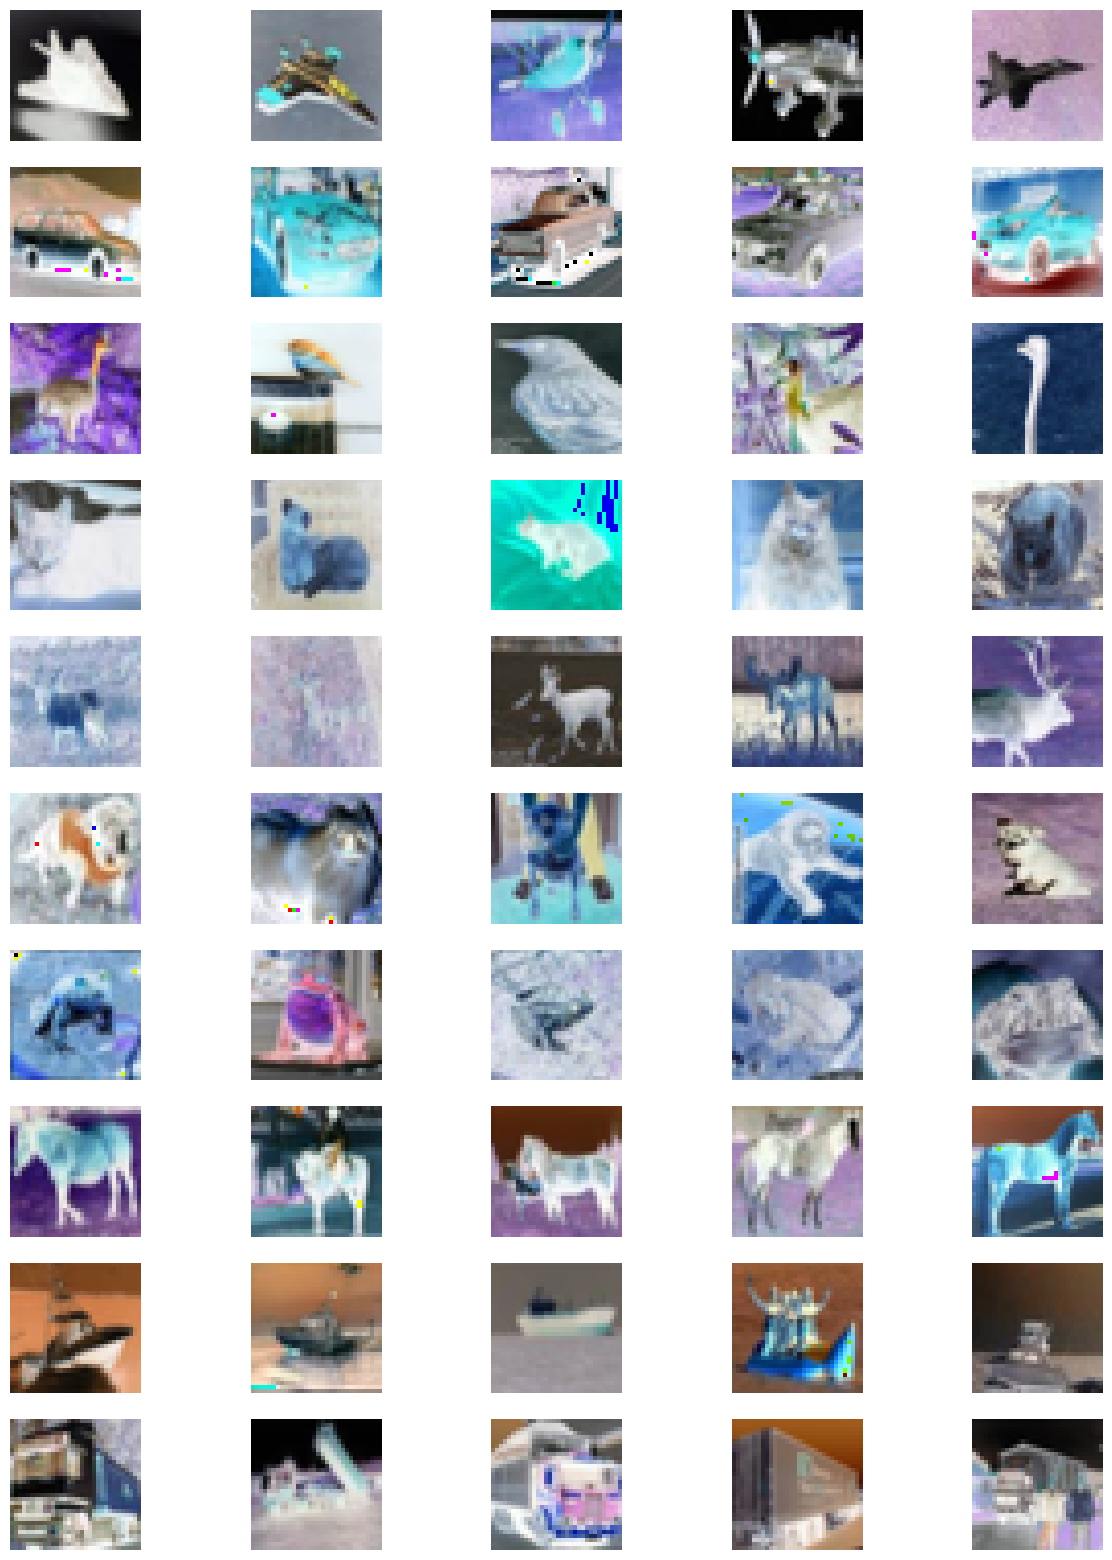

In [50]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def show_images(X, y, classes):
    num_classes = len(classes)
    fig, axs = plt.subplots(num_classes, 5, figsize=(15, 20))
    for i in range(num_classes):
        class_images = X[y == i]
        for j in range(5):
            axs[i, j].imshow((class_images[j] * 255).astype(np.uint8))
            axs[i, j].axis('off')
        axs[i, 0].set_ylabel(classes[i])
    plt.show()

show_images(X_train, y_train, classes)

1.3 Разделите данные на обучающу и тестовую выборки (X_train, y_train, X_test, y_test). Преобразуйте каждое изображение в одномерный массив. 

In [61]:
num_training = 5000
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 500
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train.shape, X_test.shape)

X_train_flat = X_train.reshape(len(X_train), -1)
X_test_flat = X_test.reshape(len(X_test), -1)

print("Размеры обучающей выборки:", X_train_flat.shape)
print("Размеры тестовой выборки:", X_test_flat.shape)

(5000, 3072) (500, 3072)
Размеры обучающей выборки: (5000, 3072)
Размеры тестовой выборки: (500, 3072)


1.4 Напишите реализацию классификатора в скрипте /classifiers/k_nearest_neighbor.py и обучите его на сформированной выборке. 

In [62]:
class KNearestNeighbor:
    def __init__(self, k=1):
        self.k = k

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y

    def _predict(self, X):
        num_test = X.shape[0]
        num_train = self.X_train.shape[0]
        y_pred = np.zeros(num_test, dtype=int)
        for i in range(num_test):
            distances = np.sqrt(np.sum(np.square(self.X_train - X[i]), axis=1))

            closest_indices = np.argsort(distances)[:self.k]

            closest_labels = self.y_train[closest_indices]

            y_pred[i] = mode(closest_labels.flatten())[0]

        return y_pred

    def predict(self, X):
        return self._predict(X)

    def get_params(self, deep=True):
        return {"k": self.k}

In [63]:
classifier = KNearestNeighbor()
classifier.fit(X_train, y_train)

1.5 Выполните классификацию на тестовой выборке

In [64]:
y_pred = classifier.predict(X_test_flat)

accuracy = np.mean(y_pred == y_test)
print(f"Точность: {accuracy:.2%}")

Точность: 27.40%


1.6 Визуализируйте матрицу расстояний для каждого изображения из тестовой выборки до изображений из обучающей выборки. 


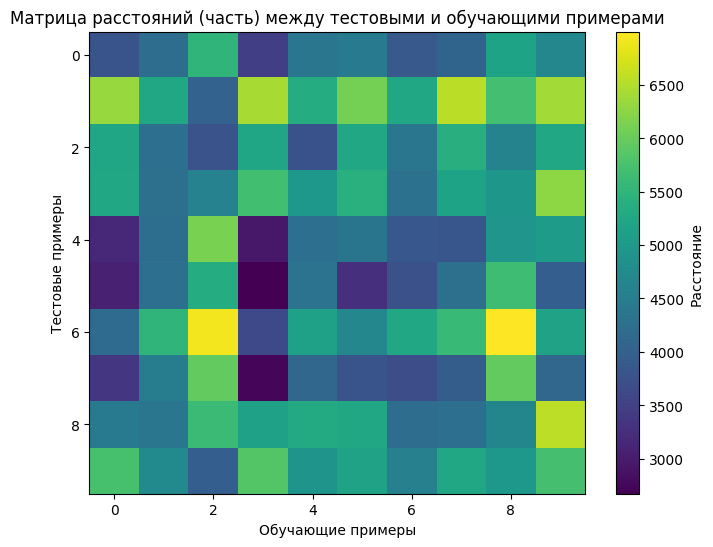

In [70]:
distances = np.sqrt(np.sum(np.square(X_train_flat), axis=1) + np.sum(np.square(X_test_flat), axis=1)[:, np.newaxis] - 2 * np.dot(X_test_flat, X_train_flat.T))

num_display = 10

plt.figure(figsize=(8, 6))
plt.imshow(distances[:num_display, :num_display], cmap='viridis', aspect='auto')
plt.colorbar(label='Расстояние')
plt.xlabel('Обучающие примеры')
plt.ylabel('Тестовые примеры')
plt.title('Матрица расстояний (часть) между тестовыми и обучающими примерами')
plt.show()


1.7 Посчитайте долю правильно классифицированных изображений из тестовой выборки.


In [71]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.30      0.33      0.31        57
           1       0.58      0.17      0.26        41
           2       0.19      0.33      0.24        51
           3       0.25      0.16      0.20        49
           4       0.14      0.40      0.21        40
           5       0.32      0.19      0.24        48
           6       0.29      0.28      0.28        54
           7       0.47      0.15      0.23        47
           8       0.41      0.58      0.48        57
           9       0.55      0.11      0.18        56

    accuracy                           0.27       500
   macro avg       0.35      0.27      0.26       500
weighted avg       0.35      0.27      0.27       500



1.8 Постройте график зависимости доли правильно классифицированных изображений от числа соседей, используемых при классификации.

1.9 Выберите лучшее значение параметра k на основе кросс-валидации.

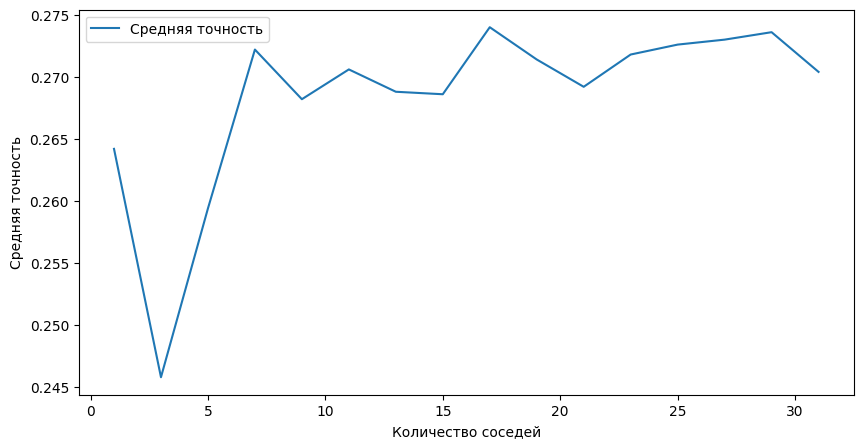

Лучшее значение k: 17


In [73]:
list_mean_accuracy = []

for k in range(1, 32, 2):
    cv_accuracies = []
    kf = StratifiedKFold(n_splits=4, shuffle=True, random_state=7575)
    for train_index, test_index in kf.split(X_train, y_train):
        X_train_fold, X_val_fold = X_train[train_index], X_train[test_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]

        classifier = KNearestNeighbor(k=k)
        classifier.fit(X_train_fold, y_train_fold)

        y_pred = classifier.predict(X_val_fold)

        acc = accuracy_score(y_val_fold, y_pred)
        cv_accuracies.append(acc)

    list_mean_accuracy.append(np.mean(cv_accuracies))

plt.figure(figsize=(10, 5))
plt.plot(range(1, 32, 2), list_mean_accuracy, label='Средняя точность')
plt.xlabel("Количество соседей")
plt.ylabel("Средняя точность")
plt.legend(loc='best')
plt.show()

best_k = (np.argmax(list_mean_accuracy) * 2) + 1
print(f"Лучшее значение k: {best_k}")


1.10 Переобучите и протестируйте классификатор с использованием выбранного значения k.



In [74]:
preds = classifier.predict(X_test.reshape(-1, X_test.shape[-1]))
print(f'Точность: {accuracy_score(y_test, preds)}')
print(f'Точность: {precision_score(y_test, preds, average="macro")}')
print(f'Полнота: {recall_score(y_test, preds, average="macro")}')
print(f'F1: {f1_score(y_test, preds, average="macro")}')

Точность: 0.23
Точность: 0.2609396604971826
Полнота: 0.21439385552653314
F1: 0.1697902665602995


/home/egor/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1.11 Сделайте выводы по результатам 1 части задания.

Точность классификации на тестовой выборке с использованием базовой реализации k-NN с одним соседом составила около 27.4%, что является относительно низким результатом.

При использовании кросс-валидации было определено, что оптимальным значением параметра k для данной задачи является 17.

После переобучения классификатора с использованием выбранного значения k точность классификации на тестовой выборке составила около 23%, что также является относительно низким результатом.

## 3.  Построение softmax-классификатора

3.1 Разделите данные на обучающую, тестовую и валидационную выборки. Преобразуйте каждое изображение в одномерный массив. Выведите размеры выборок.

In [80]:
X_train_temp, X_temp, y_train_temp, y_temp = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

X_train_flat = X_train_temp.reshape(len(X_train_temp), -1)
X_test_flat = X_test.reshape(len(X_test), -1)
X_val_flat = X_val.reshape(len(X_val), -1)

print("Размеры обучающей выборки:", X_train_flat.shape)
print("Размеры тестовой выборки:", X_test_flat.shape)
print("Размеры валидационной выборки:", X_val_flat.shape)

Размеры обучающей выборки: (4000, 3073)
Размеры тестовой выборки: (500, 3073)
Размеры валидационной выборки: (500, 3073)


3.2 Проведите предварительную обработку данных, путем вычитания среднего изображения, рассчитанного  по обучающей выборке.

3.3 Чтобы далее не учитывать смещение (свободный член b), добавьте дополнитульную размерность к массиву данных и заполните ее единицами.

In [86]:
mean_image = np.mean(X_train_flat, axis=0)
X_train_flat -= mean_image
X_test_flat -= mean_image
X_val_flat -= mean_image

X_train_with_bias = np.hstack([X_train_flat, np.ones((X_train_flat.shape[0], 1))])
X_test_with_bias = np.hstack([X_test_flat, np.ones((X_test_flat.shape[0], 1))])
X_val_with_bias = np.hstack([X_val_flat, np.ones((X_val_flat.shape[0], 1))])

print("Размеры обучающей выборки с учетом смещения:", X_train_with_bias.shape)
print("Размеры тестовой выборки с учетом смещения:", X_test_with_bias.shape)
print("Размеры валидационной выборки с учетом смещения:", X_val_with_bias.shape)

Размеры обучающей выборки с учетом смещения: (4000, 3074)
Размеры тестовой выборки с учетом смещения: (500, 3074)
Размеры валидационной выборки с учетом смещения: (500, 3074)


3.4 Реализуйте функции в classifiers/softmax.py




In [88]:

def softmax_loss_naive(W, X, y, reg):
    """
    Вычисляет функцию потерь и градиент для softmax-классификатора.

    Параметры:
    - W: массив весов размерности (D, C), где D - размерность данных, C - количество классов.
    - X: массив данных обучения размерности (N, D), где N - количество примеров, D - размерность каждого примера.
    - y: массив меток классов размерности (N,) для обучающих данных.
    - reg: коэффициент регуляризации.

    Возвращает кортеж:
    - loss: значение функции потерь.
    - dW: градиент по весам W.
    """
    
    loss = 0.0
    dW = np.zeros_like(W)
    num_train = X.shape[0]
    num_classes = W.shape[1]

    for i in range(num_train):
        scores = X[i].dot(W)
        scores -= np.max(scores)
        probs = np.exp(scores) / np.sum(np.exp(scores))
        loss += -np.log(probs[y[i]])

        dscores = probs
        dscores[y[i]] -= 1
        dW += np.outer(X[i], dscores)

    loss /= num_train
    loss += 0.5 * reg * np.sum(W * W)
    dW /= num_train
    dW += reg * W

    return loss, dW
def grad_check_sparse(f, x, analytic_grad, num_checks):
    """
    Проверяет аналитический градиент, вычисленный функцией f,
    путем сравнения его с численно вычисленным приближенным градиентом.

    Параметры:
    - f: функция, принимающая один аргумент и возвращающая значение и градиент
    - x: точка, в которой вычисляется градиент
    - analytic_grad: аналитически вычисленный градиент
    - num_checks: количество случайных точек, в которых производится проверка

    Возвращает:
    - нет, но выводит сообщение о прохождении или неудачи проверки
    """
    h = 1e-5

    for _ in range(num_checks):
        ix = tuple(np.random.randint(s) for s in x.shape)

        oldval = x[ix]
        x[ix] = oldval + h
        fxph, _ = f(x)
        x[ix] = oldval - h
        fxmh, _ = f(x)
        x[ix] = oldval

        grad_numerical = (fxph - fxmh) / (2 * h)
        grad_analytic = analytic_grad[ix]
        rel_error = np.abs(grad_numerical - grad_analytic) / (np.abs(grad_numerical) + np.abs(grad_analytic))
        print(f"numerical: {grad_numerical}, analytic: {grad_analytic}, relative error: {rel_error}")

def softmax_loss_vectorized(W, X, y, reg):
    """
    Вычисляет функцию потерь и градиент для softmax-классификатора (векторизованная версия).

    Параметры:
    - W: массив весов размерности (D, C), где D - размерность данных, C - количество классов.
    - X: массив данных обучения размерности (N, D), где N - количество примеров, D - размерность каждого примера.
    - y: массив меток классов размерности (N,) для обучающих данных.
    - reg: коэффициент регуляризации.

    Возвращает кортеж:
    - loss: значение функции потерь.
    - dW: градиент по весам W.
    """
    num_train = X.shape[0]

    scores = X.dot(W)
    scores -= np.max(scores, axis=1, keepdims=True)
    probs = np.exp(scores) / np.sum(np.exp(scores), axis=1, keepdims=True)

    correct_logprobs = -np.log(probs[range(num_train), y])
    data_loss = np.sum(correct_logprobs) / num_train
    reg_loss = 0.5 * reg * np.sum(W * W)
    loss = data_loss + reg_loss

    dscores = probs
    dscores[range(num_train), y] -= 1

    dW = X.T.dot(dscores) / num_train
    dW += reg * W

    return loss, dW


In [90]:
W = np.random.randn(X_temp.shape[1], 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_temp, y_temp, 0.0)

print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.393459
sanity check: 2.302585


3.5 Убедитесь, что вы верно реализовали расчет градиента, сравнив с реализацией численными методами (код приведен ниже).

In [92]:
loss, grad = softmax_loss_naive(W, X_temp, y_temp, 0.0)

f = lambda w: softmax_loss_naive(w, X_temp, y_temp, 0.0)
grad_numerical = grad_check_sparse(f, W, grad, 10)

loss, grad = softmax_loss_naive(W, X_temp, y_temp, 5e1)
f = lambda w: softmax_loss_naive(w, X_temp, y_temp, 5e1)
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 1.613444706682898, analytic: 1.6134446842487684, relative error: 6.952246249319039e-09
numerical: -4.990298801321735, analytic: -4.990298808427978, relative error: 7.120057318460004e-10
numerical: 0.814658490333464, analytic: 0.8146584893044635, relative error: 6.315533222161474e-10
numerical: -0.4161403533986529, analytic: -0.41614041331446666, relative error: 7.198990551167604e-08
numerical: -1.3169595882711604, analytic: -1.3169597773673478, relative error: 7.179270172127322e-08
numerical: 1.0029363886721043, analytic: 1.002936362764402, relative error: 1.2915925204764859e-08
numerical: 0.3161295870413028, analytic: 0.3161295779596657, relative error: 1.4363788793768854e-08
numerical: 3.3987461564688455, analytic: 3.398746156612097, relative error: 2.1074188271239947e-11
numerical: 2.8144325407986055, analytic: 2.814432411353333, relative error: 2.2996691762765502e-08
numerical: 0.9962724871970251, analytic: 0.9962723294678608, relative error: 7.915965702048442e-08
numeri

3.6 Сравните softmax_loss_naive и softmax_loss_vectorized реализации

In [93]:
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_temp, y_temp, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_temp, y_temp, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.393459e+00 computed in 0.389219s
vectorized loss: 2.393459e+00 computed in 0.005005s
Loss difference: 0.000000
Gradient difference: 0.000000


3.7 Реализуйте стохастический градиентный спуск в /classifiers/linear_classifier.py . Реализуйте методы train() и predict() и запустите следующий код

3.8 Обучите Softmax-классификатор и оцените accuracy на тестовой выборке.

In [94]:
class SoftmaxClassifier:
    def __init__(self):
        self.W = None

    def train(self, X, y, learning_rate=1e-3, reg_strength=1e-5, num_iters=100, batch_size=200, verbose=False):
        num_train, num_features = X.shape
        num_classes = np.max(y) + 1

        if self.W is None:
            self.W = 0.001 * np.random.randn(num_features, num_classes)

        for it in range(num_iters):
            indices = np.random.choice(num_train, batch_size)
            X_batch = X[indices]
            y_batch = y[indices]

            scores = X_batch.dot(self.W)
            exp_scores = np.exp(scores)
            probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
            correct_logprobs = -np.log(probs[range(batch_size), y_batch])

            data_loss = np.sum(correct_logprobs) / batch_size
            reg_loss = 0.5 * reg_strength * np.sum(self.W * self.W)
            loss = data_loss + reg_loss

            if verbose and it % 100 == 0:
                print(f"iteration {it} / {num_iters}: loss {loss}")

            dscores = probs
            dscores[range(batch_size), y_batch] -= 1
            dscores /= batch_size

            dW = X_batch.T.dot(dscores)
            dW += reg_strength * self.W

            self.W -= learning_rate * dW

    def predict(self, X):
        scores = X.dot(self.W)
        return np.argmax(np.exp(scores) / np.sum(np.exp(scores), axis=1, keepdims=True), axis=1)

In [95]:
softmax_classifier = SoftmaxClassifier()

softmax_classifier.train(X_train, y_train)

y_pred = softmax_classifier.predict(X_test)
accuracy = np.mean(y_pred == y_test)
print("Accuracy:", accuracy)

/tmp/ipykernel_6358/4039761518.py:18: RuntimeWarning: overflow encountered in exp
  exp_scores = np.exp(scores)
/tmp/ipykernel_6358/4039761518.py:19: RuntimeWarning: invalid value encountered in divide
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
/tmp/ipykernel_6358/4039761518.py:20: RuntimeWarning: divide by zero encountered in log
  correct_logprobs = -np.log(probs[range(batch_size), y_batch])


Accuracy: 0.094


3.9 С помощью кросс-валидации выберите значения параметров скорости обучения и регуляризации. В кросс-валидации используйте обучающую и валидационную выборки. Оцените accuracy на тестовой выборке.

In [96]:
learning_rates = [1e-7, 5e-5]
regularization_strengths = [2.5e4, 5e4]

In [97]:

param_combinations = list(itertools.product(learning_rates, regularization_strengths))
accuracy_scores = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for lr, reg in param_combinations:
    cv_scores = []

    for train_index, val_index in skf.split(X_train_flat, y_train_temp):
        X_train_fold, X_val_fold = X_train_flat[train_index], X_train_flat[val_index]
        y_train_fold, y_val_fold = y_train_temp[train_index], y_train_temp[val_index]

        softmax_clf = SoftmaxClassifier()
        softmax_clf.train(X_train_fold, y_train_fold, learning_rate=lr, reg_strength=reg, num_iters=1000)

        y_pred_fold = softmax_clf.predict(X_val_fold)
        accuracy = np.mean(y_pred_fold == y_val_fold)
        cv_scores.append(accuracy)

    mean_accuracy = np.mean(cv_scores)
    accuracy_scores.append((lr, reg, mean_accuracy))

best_lr, best_reg, best_accuracy = max(accuracy_scores, key=lambda x: x[2])

print("Best learning rate:", best_lr)
print("Best regularization strength:", best_reg)
print("Best cross-validation accuracy:", best_accuracy)

/tmp/ipykernel_6358/4039761518.py:18: RuntimeWarning: overflow encountered in exp
  exp_scores = np.exp(scores)
/tmp/ipykernel_6358/4039761518.py:19: RuntimeWarning: invalid value encountered in divide
  probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
/tmp/ipykernel_6358/4039761518.py:20: RuntimeWarning: divide by zero encountered in log
  correct_logprobs = -np.log(probs[range(batch_size), y_batch])


Best learning rate: 1e-07
Best regularization strength: 25000.0
Best cross-validation accuracy: 0.3295


In [98]:
softmax_clf = SoftmaxClassifier()

softmax_clf.train(X_train_flat, y_train_temp, learning_rate=best_lr, reg_strength=best_reg, num_iters=1000)

y_pred_test = softmax_clf.predict(X_test_flat)

test_accuracy = np.mean(y_pred_test == y_test)
print("Accuracy on test set:", test_accuracy)


Accuracy on test set: 0.334


3.10 Сделайте выводы по третьей части задания

1)Точность классификации на тестовой выборке после обучения softmax-классификатора оказалась низкой, составив около 0.094. Это говорит о том, что классификатор плохо справляется с задачей распознавания классов на данном наборе данных.

2)После проведения кросс-валидации были выбраны оптимальные значения параметров скорости обучения и регуляризации: learning_rate=1e-07 и regularization_strength=25000.0. Лучшая оценка кросс-валидации составила 0.3295.

3)После повторного обучения softmax-классификатора с использованием оптимальных параметров, точность классификации на тестовой выборке улучшилась до около 0.334. Однако это все еще недостаточно для эффективного решения задачи.